In [19]:
import pandas as pd
from Bio import SeqIO
import random
import numpy as np

In [20]:
# Resources
# https://www.youtube.com/watch?v=bxe2T-V8XRs
# https://towardsdatascience.com/lets-code-a-neural-network-in-plain-numpy-ae7e74410795
# https://gist.github.com/drudi/ec1e354564a4aaad77f693cc0c80e7fd
# https://enlight.nyc/projects/neural-network/
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedKFold.html#sklearn.model_selection.RepeatedKFold

In [21]:
# yeast genome as negative training data
# 3k fa sequences 1k bases upstream from ORF
# possibly some that correspond to single positive seq - remove from training
records = list(SeqIO.parse("yeast-upstream-1k-negative.fa", "fasta"))
print(records[0])
print(records[0].seq)

ID: YAL003W
Name: YAL003W
Description: YAL003W 5' untranslated region, chrI 141172 - 142171, 1000 bp
Number of features: 0
Seq('CTTCATGTCAGCCTGCACTTCTGGGTCGTTGAAGTTTCTACCGATCAAACGCTT...ATA', SingleLetterAlphabet())
CTTCATGTCAGCCTGCACTTCTGGGTCGTTGAAGTTTCTACCGATCAAACGCTTAGCGTCGAAAACGGTATTCGAAGGATTCATAGCAGCTTGATTCTTAGCAGCATCACCAATCAATCTTTCAGTGTCAGTGAAAGCGACAAAAGATGGAGTGGTTCTGTTACCTTGATCGTTGGCAATAATGTCCACACGATCATTAGCAAAGTGAGCAACACACGAGTATGTTGTACCTAAATCAATACCGACAGCTTTTGACATATTATCTGTTATTTACTTGAATTTTTGTTTCTTGTAATACTTGATTACTTTTCTTTTGATGTGCTTATCTTACAAATAGAGAAAATAAAACAACTTAAGTAAGAATTGGGAAACGAAACTACAACTCAATCCCTTCTCGAAGATACATCAATCCACCCCTTATATAACCTTGAAGTCCTCGAAACGATCAGCTAATCTAAATGGCCCCCCTTCTTTTTGGGTTCTTTCTCTCCCTTTTGCCGCCGATGGAACGTTCTGGAAAAAGAAGAATAATTTAATTACTTTCTCAACTAAAATCTGGAGAAAAAACGCAAATGACAGCTTCTAAACGTTCCGTGTGCTTTCTTTCTAGAATGTTCTGGAAAGTTTACAACAATCCACAAGAACGAAAATGCCGTTGACAATGATGAAACCATCATCCACACACCGCGCACACGTGCTTTATTTCTTTTTCTGAATTTTTTTTTTCCGCCATTTTCAACCAAGGAAATTTTTTTTCTTAGGGCTCAGAACCTGCAGGTGAAGAA

In [22]:
# 137 real rap1 binding sites, 17bp long
seq_pos = pd.read_csv('rap1-lieb-positives.txt',header=None)
seq_pos.columns = ['sequence']
seq_pos['probability'] = 1.0
print(seq_pos.head(1))
print(len(seq_pos))

            sequence  probability
0  ACATCCGTGCACCTCCG          1.0
137


In [23]:
seq_test = pd.read_csv('rap1-lieb-test.txt',header=None)
print(len(seq_test))

3195


In [24]:
# 1) 
# linear position weight matrix based on positive sequences
# along with model backgroung probabilities of observed sequences
# (some caveats listed in pdf)
# feed forward, 3 layer neural net with standard sigmoidal units
# Vary size input layer, hidden layer, and output layer
# must support cross-validation (look at Keiser 2nd presentation on machine learning)
# learn 8x3x8 encoder problem

In [25]:
# collect all the negative sequences into a df
# now at 3 hours
collect_neg = []
for r in records:
    seq = ''.join(r.seq)
    collect_neg.append(seq)

seq_neg = pd.DataFrame({'sequence':collect_neg})
print(seq_neg.head())

                                            sequence
0  CTTCATGTCAGCCTGCACTTCTGGGTCGTTGAAGTTTCTACCGATC...
1  CCAATTTGTCACCAGCTTCAGAAATGGTGTTCTTCAAAGAGTAAGC...
2  CACTCATATCGGGGGTCTTACTTCCCATCATAAACACGGACCAAAG...
3  AGAGAAAGAGTTTCACTTCTTGATTATCGCTAACACTAATGGTTGA...
4  GTGTCCGGGCCTCGCAGGCGTTCTACTAGCAAGACATCCAGTGCGA...


In [26]:
# remove any negative sequence that contains a positive sequence
# this is sloppy - removes the whole sequence if the posistive is apart of it...
collect_nopos = []
doc_nopos = []
for i,r in seq_pos.iterrows():
    for j,s in seq_neg.iterrows():
        if r['sequence'] in s['sequence']:
            with_pos = [i,j]
            doc_nopos.append(with_pos) 
        else:
            collect_nopos.append(s['sequence'])

seq_nopos = pd.DataFrame({'sequence':collect_nopos})
print(seq_nopos.head())
print(len(seq_nopos))
doc_overlap = pd.DataFrame({'from_pos':doc_nopos[0],'from_neg':doc_nopos[1]})
print(doc_overlap.head())

                                            sequence
0  CTTCATGTCAGCCTGCACTTCTGGGTCGTTGAAGTTTCTACCGATC...
1  CCAATTTGTCACCAGCTTCAGAAATGGTGTTCTTCAAAGAGTAAGC...
2  CACTCATATCGGGGGTCTTACTTCCCATCATAAACACGGACCAAAG...
3  AGAGAAAGAGTTTCACTTCTTGATTATCGCTAACACTAATGGTTGA...
4  GTGTCCGGGCCTCGCAGGCGTTCTACTAGCAAGACATCCAGTGCGA...
433400
   from_pos  from_neg
0         1         4
1        21        90


In [27]:
collect = []
k = 17 # length of binding site
pos_list = seq_pos['sequence'].tolist()

for i,n in seq_neg.iterrows():
    while len(collect) < len(pos_list):
        neg_str = n['sequence']
        start = random.randint(0,len(neg_str)-k)
        sub_string = neg_str[start:start+k]
        if sub_string in pos_list:
            continue
        else:
            collect.append(sub_string)
print(len(collect),len(pos_list))

137 137


In [28]:
pd_seq = pd.DataFrame(collect)
pd_seq.columns = ['sequence']
pd_seq['probability'] = 0.0
print(pd_seq.head())

            sequence  probability
0  AGGGCTCAGAACCTGCA          0.0
1  GAATATATACACACATA          0.0
2  TACCTTGATCGTTGGCA          0.0
3  AAGAATAATTTAATTAC          0.0
4  AGTGTCAGTGAAAGCGA          0.0


In [29]:
def make_binary_sequence(str_seq):
    bin_seq = []
    binary_dict = {"A": [1,0,0,0],"C": [0,1,0,0],"G": [0,0,1,0],"T": [0,0,0,1]}
    temp = [bin_seq.append(binary_dict[s]) for s in str_seq]
    return np.array(bin_seq).flatten()

pd_seq['binary'] = [make_binary_sequence(seq) for seq in seq_pos['sequence']]
print(pd_seq.head())

            sequence  probability  \
0  AGGGCTCAGAACCTGCA          0.0   
1  GAATATATACACACATA          0.0   
2  TACCTTGATCGTTGGCA          0.0   
3  AAGAATAATTTAATTAC          0.0   
4  AGTGTCAGTGAAAGCGA          0.0   

                                              binary  
0  [1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...  
1  [1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...  
2  [0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...  
3  [0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...  
4  [1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...  


In [30]:
cutoff = int(len(seq_test)*.7)
train = seq_test[:cutoff]
test = seq_test[cutoff:]
print(len(train))
print(len(test))

2236
959


In [31]:
seq_pos
seq_pos['binary'] = [make_binary_sequence(seq) for seq in seq_pos['sequence']]

concat_pos = pd.concat([seq_pos,pd_seq])
print(len(seq_pos),len(pd_seq),len(concat_pos))
print(concat_pos.head())

137 137 274
            sequence  probability  \
0  ACATCCGTGCACCTCCG          1.0   
1  ACACCCAGACATCGGGC          1.0   
2  CCACCCGTACCCATGAC          1.0   
3  GCACCCATACATTACAT          1.0   
4  ACATCCATACACCCTCT          1.0   

                                              binary  
0  [1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...  
1  [1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...  
2  [0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...  
3  [0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...  
4  [1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...  


In [32]:
sizes = [8,3,8]
weights = [np.random.randn(i, j) for i, j in zip(sizes[:-1], sizes[1:])]
# input to hidden, hidden to output
print(weights[1])

[[-0.02572519  0.79840656  0.08300596  0.23502525  0.58914407 -0.1007386
  -0.25347957  1.66763039]
 [-0.67155822  1.74991802 -1.55298835  1.44660055  1.42699379 -1.66012563
   1.63945736 -0.32125642]
 [ 1.562404    1.96257558 -0.28279973 -0.28146745  0.01079766 -0.55098996
   1.47231272  0.7985505 ]]


In [33]:
reverse_weights = [w.T for w in weights]
print(weights[0].shape)
print(reverse_weights[0].shape)
print(weights[-1])

(8, 3)
(3, 8)
[[-0.02572519  0.79840656  0.08300596  0.23502525  0.58914407 -0.1007386
  -0.25347957  1.66763039]
 [-0.67155822  1.74991802 -1.55298835  1.44660055  1.42699379 -1.66012563
   1.63945736 -0.32125642]
 [ 1.562404    1.96257558 -0.28279973 -0.28146745  0.01079766 -0.55098996
   1.47231272  0.7985505 ]]


In [34]:
x = np.identity(8)
my_train = [[i,i] for i in x]
print(my_train)

[[array([1., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0.])], [array([0., 1., 0., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0.])], [array([0., 0., 1., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0.])], [array([0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0.])], [array([0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0.])], [array([0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0.])], [array([0., 0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0.])], [array([0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 1.])]]


In [35]:
neurons = [8,3,8]
layers = len(neurons)
biases = [np.random.randn(i, 1) for i in neurons[1:]]
weights = [np.random.randn(i, j) for i, j in zip(neurons[:-1], neurons[1:])]
x = [1,0,0,0,0,0,0,0]
y = [1,0,0,0,0,0,0,0]
def sigmoid(s):
    return 1/(1+np.exp(-s))
    
outputs = []
products = []
for w,b in zip(weights,biases):
    p = np.dot(w.T, x)+b
    products.append(p)
    activation = sigmoid(p)
    outputs.append(activation)
    x = activation
print(outputs[-1])

[[0.10636776 0.11612155 0.08693981]
 [0.8236898  0.81384591 0.84719059]
 [0.73435557 0.71755686 0.77337629]
 [0.70595843 0.6774308  0.77062296]
 [0.27311717 0.26454514 0.29909851]
 [0.51676906 0.51908024 0.52246266]
 [0.76590321 0.75485935 0.7877221 ]
 [0.26171309 0.30967072 0.17307003]]


In [36]:
neurons = [8,3,8]
layers = len(neurons)
for i in reversed(range(1,layers)):
    print(i)

2
1


In [37]:
np.random.permutation(10)

array([4, 0, 3, 8, 9, 2, 7, 5, 6, 1])

In [38]:
pos = seq_pos
neg = pd.concat([pd_seq,pd_seq])
sub_pos = pos.sample((len(neg)-len(pos)))
print(len(pos),len(neg),len(sub_pos))

137 274 137


In [39]:
def sigmoid(s):
    s = float(s)
    return 1/(1+np.exp(-s))
print(sigmoid(10000000000000000000),sigmoid(-10000000000000000000))

1.0 0.0


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


In [40]:
error_list = [1,1,1,1,1]
print(sum(error_list)/len(error_list))

1.0


In [41]:
df = np.identity(8)
df_shuffle = np.random.permutation(len(x))
cutoff = int(len(df_shuffle)*.7)
train_index = df_shuffle[:cutoff]
hold_index = df_shuffle[cutoff:]
print(df_shuffle)
print(hold_index)

[4 5 6 2 3 1 7 0]
[1 7 0]


In [42]:
list = [np.nan,np.nan,1]
if np.isnan(list).any():
    print('yup')

yup


In [43]:
np.random.randn(8,3)

array([[ 0.57478524, -1.33204094,  0.16601857],
       [-1.59936991, -1.57107893, -0.20001066],
       [ 0.83848722,  0.84269257, -0.26069433],
       [-1.38346075,  0.64032684,  1.05442608],
       [ 0.63401388,  0.25237333,  1.83018417],
       [ 0.84324512, -0.75656709, -1.34603964],
       [-0.28992746,  0.18024153,  0.81370334],
       [ 0.21263132,  1.91294354, -0.75688669]])

In [44]:
x = np.identity(8)
y = np.identity(8)
shuffle = np.random.permutation(len(x))
t = x[shuffle]
best = sum(x==y)
print(sum(x==y)/best,sum(x==t)/best)
print(t)

[1. 1. 1. 1. 1. 1. 1. 1.] [0.75 1.   0.75 0.75 0.75 0.75 0.75 0.75]
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]]


In [523]:
'''
Script to read in the data sets
Wren Saylor 2019
'''
import pandas as pd
from Bio import SeqIO,Seq
import numpy as np
import random

def reverse_complement_dictionary(sequence):
    '''
    dicationary with reverse complement nucs
    '''
    seqDict = {'A':'T','T':'A','C':'G','G':'C','N':'N'}
    return "".join([seqDict[base] for base in reversed(sequence)])

def read_from_csv(file,value):
    '''
    for those data sets from csv files, read into panda
    add sequence and probability columns, get revese complement to boost #s
    '''
    pd_seq = pd.read_csv(file,header=None)

    # label columns and make probabilty
    pd_seq.columns = ['sequence']
    pd_seq['probability'] = value

    # make binary sequence, where each letter is coded as 4 digit 0/1
    pd_seq['binary'] = [make_binary_sequence(seq) for seq in pd_seq['sequence']]
    return pd_seq

def read_from_fa(file):
    '''
    for those data sets from fa files (the negative sequences)
    '''
    records = SeqIO.parse(file, "fasta")

    # get just the sequences from the record
    collect = []

    # collect just the sequences
    for r in records:
        seq = ''.join(r.seq)
        collect.append(seq)
    return pd.DataFrame({'sequence':collect})

def remove_positives(pos,neg):
    '''
    remove all negative sequences that contain positives
    make panda for which positive and negative sequences overlap,
    incase need later
    '''
    collect = []

    # for each row in pos sequences, go through the negative rows
    # if the positive sequece is in the negative, collect those indeces to
    # overlap list, other wise, collect the sequence
    pos_seq = pos['sequence'].tolist()
    neg_seq = neg['sequence'].tolist()
#     print(pos_seq)
    for n in neg_seq:
        for p in pos_seq:
            collect.append(n.replace(p, ""))
    pd_seq = pd.DataFrame({'sequence':collect})
    return pd_seq

def subsample_negative(pos,neg,size):
    '''
    get the same number of negative sequence as have posistive
    with same size elements (17)
    make sure the sequences are not already in the positive set
    make into panda with columns sequence and probablity
    '''
    collect = []
    k = 17 # length of binding site
    pos_list = pos['sequence'].tolist()

    # for each negative row, while the number of sequences in the collected list
    # is less than the size indicated to collect, continue collecting,
    # unless the negative sequence is in the positive list
    for i,n in neg.iterrows():
        while len(collect) < size:
            neg_str = n['sequence']
            start = random.randint(0,len(neg_str)-k)
            sub_string = neg_str[start:start+k]
            if sub_string in pos_list:
                continue
            else:
                collect.append(sub_string)
    pd_seq = pd.DataFrame(collect)
    pd_seq.columns = ['sequence']
    pd_seq['probability'] = 0.0
    return pd_seq

def select_negatives(neg_file,seq_pos):
    '''
    run all the functions necessary to create the negative sequences data set
    formated in the same way and complementry to the positives
    '''
    neg_read_fa = read_from_fa(neg_file)
    neg_no_overlaps = remove_positives(seq_pos,neg_read_fa)
    neg_subsample = subsample_negative(seq_pos,neg_no_overlaps,500)#len(pos_list*2)
    neg_subsample['binary'] = [make_binary_sequence(seq) for seq in neg_subsample['sequence']]
    return neg_subsample

def make_binary_sequence(seq):
    '''
    convert the sequence into binary by exchanging each letter with a four
    digit 1/0 code
    '''
    bin_seq = []
    bin_dict = {"A": [1,0,0,0],"C": [0,1,0,0],"G": [0,0,1,0],"T": [0,0,0,1]}
    temp = [bin_seq.append(bin_dict[s]) for s in seq]
    return np.array(bin_seq).flatten()

def make_training_and_holdout(df):
    '''
    shuffle the dataframe, then seperate into training and test sets with ratio 7:3
    '''
    # shuffle the entire df
    df_shuffle = df.sample(frac=1).reset_index(drop=True)

    # the cutoff value for seperating into training and test
    # is at 70% of the seqneces
    cutoff = int(len(df_shuffle)*.7)
    train = df_shuffle[:cutoff]
    test = df_shuffle[cutoff:]
    return train,test

def assemble_positive_dataset(file_pos):
    # get positive sequences
    read_pos = read_from_csv(file_pos,1.0)
    # revrse complement
    reverse = [reverse_complement_dictionary(i) for i in read_pos['sequence']]
    pd_rev = pd.DataFrame(reverse,columns=['sequence'])
    pd_rev['probability'] = 1.0
    pd_rev['binary'] = [make_binary_sequence(seq) for seq in pd_rev['sequence']]
    
    # concat with reverse complement
    seq_pos = pd.concat([read_pos,pd_rev])
    return seq_pos  
    
def collect_datasets(file_pos,file_neg,file_test):
    '''
    get positive, negative, and test datasets
    all in pandas, with sequence and probability columns
    '''

    # get test sequences
    seq_test = read_from_csv(file_test,np.nan)

    # get positive sequences
    # 137 x 2 = 274
    seq_pos = assemble_positive_dataset(file_pos)

    # get negative sequences
    seq_neg = select_negatives(file_neg,seq_pos)

    # subsample the positive sequences in order to get the same number of pos
    # as there are neg
#     collect = []
#     num_pos = len(seq_neg)-len(seq_pos)
#     for i in range(num_pos):
#         collect.append(seq_2.sample(1))
#     sample_pos = pd.concat(collect)

    # concat pos and neg seq together
    seq_all = pd.concat([seq_pos,seq_neg])#

    # get training and test sequences
    seq_train,seq_hold = make_training_and_holdout(seq_all)

    return seq_train,seq_hold,seq_test

In [525]:
# seq_test.columns = ['sequence']
seq_test['binary'] = [make_binary_sequence(seq) for seq in seq_test['sequence']]
print(seq_test.head())

            sequence  probability  \
0  AAAAAAACGCAACTAAT          NaN   
1  AAAAACACACATCTGGC          NaN   
2  AAAACCAAACACCTGAA          NaN   
3  AAAACCAAACAGCTCAG          NaN   
4  AAAACCAAACATATCAA          NaN   

                                              binary  
0  [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...  
1  [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...  
2  [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...  
3  [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...  
4  [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...  


In [526]:
def reverse_complement_dictionary(sequence):
    seqDict = {'A':'T','T':'A','C':'G','G':'C','N':'N'}
    return "".join([seqDict[base] for base in reversed(sequence)])

head = pd_concat['sequence'].head()
reverse = [reverse_complement_dictionary(i) for i in head]
# reverse=head.apply(lambda row: reverse_complement_dictionary(row['sequence']),axis=1)
cat = pd.concat([head,pd.DataFrame(reverse)])
print(cat)

                   0
0  ACATCCGTGCACCTCCG
0  AGGGCTCAGAACCTGCA
1  ACACCCAGACATCGGGC
1  GAATATATACACACATA
2  CCACCCGTACCCATGAC
0  CGGAGGTGCACGGATGT
1  TGCAGGTTCTGAGCCCT
2  GCCCGATGTCTGGGTGT
3  TATGTGTGTATATATTC
4  GTCATGGGTACGGGTGG


Text(0.5,1,'roc plot')

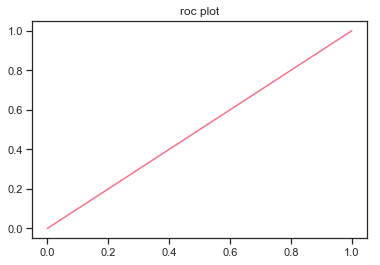

In [527]:
plt.plot(fpr,tpr)
plt.title("roc plot")

In [528]:
seq_1 = seq_pos.head(17)
seq_2 = seq_pos.tail(7)
seq_2.reset_index(inplace=True)
num_pos = len(seq_1)-len(seq_2)
collect = []
for i in range(num_pos):
    collect.append(seq_2.sample(1))

print(pd.concat(collect))

   index           sequence  probability  \
1    131  ACACCCAAGCACAGCAT          1.0   
4    134  AGACCCATACATCACAA          1.0   
6    136  ACACCCATACACCAAAC          1.0   
1    131  ACACCCAAGCACAGCAT          1.0   
6    136  ACACCCATACACCAAAC          1.0   
5    135  TAACCCATACACCTCAT          1.0   
3    133  ACACCCATACCTTTAGG          1.0   
0    130  GAATCCGTACATTTAGA          1.0   
2    132  GAATCCTTACATCACAC          1.0   
1    131  ACACCCAAGCACAGCAT          1.0   

                                              binary  
1  [1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...  
4  [1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, ...  
6  [1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...  
1  [1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...  
6  [1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...  
5  [0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...  
3  [1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...  
0  [0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...  
2  [0, 0, 1, 0, 1, 0

In [530]:
import re
cat.columns = ['sequence']
df = {'sequence':['TCC','GAGGTG','CCCAGA']}
short = pd.DataFrame(df)

def remove_positives(pos,neg):
    '''
    remove all negative sequences that contain positives
    make panda for which positive and negative sequences overlap,
    incase need later
    '''
    collect = []

    # for each row in pos sequences, go through the negative rows
    # if the positive sequece is in the negative, collect those indeces to
    # overlap list, other wise, collect the sequence
    pos_seq = pos['sequence'].tolist()
    neg_seq = neg['sequence'].tolist()
    for n in neg_seq:
        for p in pos_seq:
            collect.append(n.replace(p, ""))
    pd_seq = pd.DataFrame({'sequence':collect})
    return pd_seq

print(cat,short)

            sequence
0  ACATCCGTGCACCTCCG
0  AGGGCTCAGAACCTGCA
1  ACACCCAGACATCGGGC
1  GAATATATACACACATA
2  CCACCCGTACCCATGAC
0  CGGAGGTGCACGGATGT
1  TGCAGGTTCTGAGCCCT
2  GCCCGATGTCTGGGTGT
3  TATGTGTGTATATATTC
4  GTCATGGGTACGGGTGG   sequence
0      TCC
1   GAGGTG
2   CCCAGA


In [532]:
from sklearn.metrics import roc_curve, auc
# def perf_measure(y, p):
#     TP,FP,TN,FN = 0,0,0,0
#     for i in range(len(y)): 
#         if y[i]==p[i]==1:
#            TP += 1
#         if p[i]==1 and y[i]!=p[i]:
#            FP += 1
#         if y[i]==p[i]==0:
#            TN += 1
#         if p[i]==0 and y[i]!=p[i]:
#            FN += 1
#     return(TP, FP, TN, FN)
# t = perf_measure(y, outputs[-1])

# roc_auc_score(y, outputs[-1])

# plt.figure()
# plt.plot(fpr[2], tpr[2], color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc[2])
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
# plt.legend(loc="lower right")
# plt.show()

In [533]:
# print(pd_params.head())

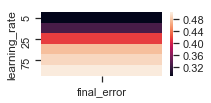

In [534]:
import seaborn as sns
import matplotlib.gridspec as gridspec

heat_params = pd_params[['learning_rate','final_error']]
group_params = heat_params.groupby('learning_rate')['final_error'].mean().reset_index()
group_params.set_index('learning_rate',drop=True,inplace=True)

sns.set_style('ticks')
sns.set_palette("husl")
gs = gridspec.GridSpec(3,2,height_ratios=[1,1,1],width_ratios=[1,1])
ax1 = plt.subplot(gs[0,0])
sns.heatmap(group_params,ax=ax1)

# import pathlib
# outdir = pathlib.Path('images')
# outfile = outdir / "Learningrate-error.png"
# outdir.mkdir(parents=True, exist_ok=True)
# plt.savefig(str(outfile),format='png')
# plt.close()

Text(0.5,1,'roc plot')

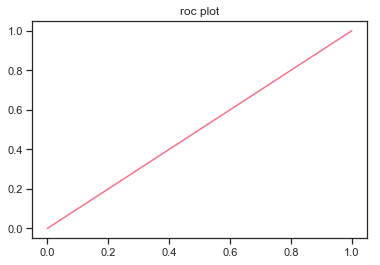

In [537]:
# learning_rates = [5,10,25,50,75,100]
# epochs = [10,100,1000]
# hidden = [[68,34,17,9,3,1],[68,68,34,34,17,17,9,9,3,3,1],[68,68,68,34,34,34,17,17,17,9,9,9,3,3,3,1]]
sub_params = pd_params[pd_params['learning_rate']==5]
x = sub_params['fpr'][1]
y = sub_params['tpr'][1]
plt.plot(x,y)
plt.title("roc plot")

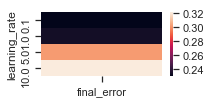

In [538]:
heat_params = pd_params_two[['learning_rate','final_error']]
group_params = heat_params.groupby('learning_rate')['final_error'].mean().reset_index()
group_params.set_index('learning_rate',drop=True,inplace=True)

sns.set_style('ticks')
sns.set_palette("husl")
gs = gridspec.GridSpec(3,2,height_ratios=[1,1,1],width_ratios=[1,1])
ax1 = plt.subplot(gs[0,0])
sns.heatmap(group_params,ax=ax1)

In [539]:
seq_train,seq_hold,seq_test = collect_datasets(
    'rap1-lieb-positives.txt',
    'yeast-upstream-1k-negative.fa',
    'rap1-lieb-test.txt')

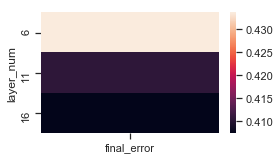

In [540]:
# sub_params = pd_params[pd_params['epochs_run']==9]
heat_params = pd_params[['layer_num','final_error']]
group_params = heat_params.groupby('layer_num')['final_error'].mean().reset_index()
group_params.set_index('layer_num',drop=True,inplace=True)

sns.set_style('ticks')
sns.set_palette("husl")
gs = gridspec.GridSpec(3,2,height_ratios=[1,1,1],width_ratios=[1,1])
gs.update(hspace=.75)
gs.update(wspace=.5)
fig = plt.figure(figsize=(10,10))
ax1 = plt.subplot(gs[0,0])
sns.heatmap(group_params,ax=ax1)

In [571]:
A = np.zeros((8, 8))
np.fill_diagonal(A, np.arange(4)+1)

my_neurons = [8,5,8]
x = np.maximum( A, A.transpose() )
y = np.maximum( A, A.transpose() )

epochs = 1000
learning_rate = 45

NN = NeuralNetwork(my_neurons)
error_list_train,error_list_valid,epochs_run = NN.gradient_descent(x,y,epochs,learning_rate)
prediction,_ = NN.feed_forward(np.identity(8))
print('final error: {0}'.format(error_list_valid[-1]))
print(prediction[-1])
print('best case is {0}'.format(evaluate_identity(y,y)))
print('predicted is {0}'.format(evaluate_identity(y,prediction[-1])))
# print(y)

Converged after 99 epochs
final error: 0.7916666666666667
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
best case is [1. 1. 1. 1. 1. 1. 1. 1.]
predicted is [0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875]


In [687]:
### make network structure
# https://medium.com/technology-invention-and-more/how-to-build-a-multi-layered-neural-network-in-python-53ec3d1d326a
# https://enlight.nyc/projects/neural-network/
# https://www.kdnuggets.com/2018/10/simple-neural-network-python.html
# https://www.python-course.eu/neural_networks_with_python_numpy.php
# favorite:
# https://dev.to/shamdasani/build-a-flexible-neural-network-with-backpropagation-in-python
from sklearn.metrics import mean_squared_error

class NeuralNetwork(object):
    np.random.seed(10)
    
    def __init__(self,neurons):
        self.neurons = neurons
        self.layers = len(neurons)
        self.biases = [np.random.randn(i) for i in neurons[1:]]
        self.weights = [np.random.randn(i, j) for i, j in zip(neurons[:-1], neurons[1:])]
        
    def feed_forward(self,x):
        outputs = []
        products = []
        for w,b in zip(self.weights,self.biases):
            product = np.dot(x, w)+b
            products.append(product)
            activation = sigmoid(product).round(2)
            outputs.append(activation)
            x = activation
        return outputs,products
    
    def backward_propogation(self,x,y,outputs,products):
        weight_deltas = []
        bias_deltas = []
        previous_delta = outputs[-1]-y
        delta_error_product = previous_delta * sigmoid_derivative(products[-1])
        bias_deltas.append(delta_error_product)
        weight_deltas.append(np.dot(delta_error_product, outputs[-1].T))
        inputs = [x] + outputs[:-1]
        for i in range(2, self.layers):
            delta_error = sigmoid_derivative(products[-i])
            delta_error_product = np.dot(self.weights[-i+1], delta_error_product) * delta_error
            bias_deltas.append(delta_error_product)
            weight_deltas.append(np.dot(delta_error_product, inputs[-i+1]))
        reverse_weight = reversed(weight_deltas)
        reverse_bias = reversed(bias_deltas)
        return reverse_weight,reverse_bias

    def training_step(self,x,y,learning_rate):
        collect_outputs = []
        for x_i,y_i in zip(x,y):
            outputs,products = self.feed_forward(x_i)
            collect_outputs.append(outputs[-1])
            weight_delta,bias_delta = self.backward_propogation(x_i,y_i,outputs,products)
            for (w,b,dw,db) in zip(self.weights,self.biases,weight_delta,bias_delta):
                b-=learning_rate*db
                w-=learning_rate*((dw.T/self.layers)) # normalized
        return collect_outputs

    def gradient_descent(self,x,y,epochs,learning_rate):
        shuffle_index = np.random.permutation(len(x))
        cutoff = int(len(shuffle_index)*.7)
        train_index = shuffle_index[:cutoff]
        hold_index = shuffle_index[cutoff:]
        error_list_train = []
        error_list_valid = []
        previous_out = []
        test_len = 1000
        for i in range(epochs):
            out_train = self.training_step(x[train_index],y[train_index],learning_rate)
            out_valid = self.training_step(x[hold_index],y[hold_index],learning_rate)
            error_list_valid.append(mean_squared_error(y[hold_index],out_valid))
            error_list_train.append(mean_squared_error(y[train_index],out_train))
            if len(error_list_valid) < test_len:
                pass
            elif sum(error_list_valid[-test_len:])/test_len == error_list_valid[-1]:
                pass
            else:
                print('Converged after {0} epochs'.format(i))
                break
        return error_list_train,error_list_valid,i
    
def evaluate_identity(y,p):
    best_case=sum(y==y)
    evaluate=sum(y==p)/best_case
    return evaluate
        
def sigmoid(s):
    return 1/(1+np.exp(np.float64(-s)))
    
def sigmoid_derivative(s):
    return sigmoid(np.float64(s)) * (1 - sigmoid(np.float64(s)))

In [688]:
### Training ###
# 8 3 8 
my_neurons = [8,5,8]
x = np.identity(8)
y = np.identity(8)

epochs = 100000
learning_rate = .01
NN = NeuralNetwork(my_neurons)
error_list_train,error_list_valid,epochs_run = NN.gradient_descent(x,y,epochs,learning_rate)
prediction,_ = NN.feed_forward(np.identity(8))
print('final error training: {0}, final error validation: {1}'.format(error_list_train[-1],error_list_valid[-1]))
print(prediction[-1])
print('best case is {0}'.format(evaluate_identity(y,y)))
print('predicted is {0}'.format(evaluate_identity(y,prediction[-1])))

Converged after 999 epochs
final error training: 0.10602249999999999, final error validation: 0.12593749999999998
[[0.02 0.19 0.07 0.11 0.06 0.15 0.13 0.02]
 [0.03 0.22 0.12 0.16 0.07 0.18 0.17 0.05]
 [0.01 0.1  0.03 0.11 0.04 0.07 0.1  0.01]
 [0.02 0.17 0.06 0.1  0.06 0.14 0.11 0.03]
 [0.02 0.13 0.04 0.11 0.09 0.08 0.09 0.02]
 [0.05 0.17 0.08 0.18 0.17 0.08 0.2  0.02]
 [0.03 0.14 0.08 0.12 0.08 0.12 0.19 0.04]
 [0.04 0.13 0.05 0.18 0.13 0.07 0.12 0.02]]
best case is [1. 1. 1. 1. 1. 1. 1. 1.]
predicted is [0. 0. 0. 0. 0. 0. 0. 0.]


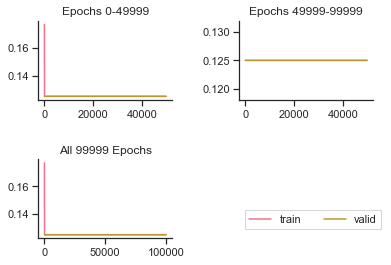

In [658]:
half = int(epochs_run/2)
quart = int(half/2)

import matplotlib.pyplot as plt

ax2 = plt.subplot(221)
h, = ax2.plot(error_list_train[:half])
j, = ax2.plot(error_list_valid[:half])
ax2.title.set_text('Epochs 0-{0}'.format(half))
ax3 = plt.subplot(222)
ax3.plot(error_list_train[half:])
ax3.plot(error_list_valid[half:])
ax3.title.set_text('Epochs {0}-{1}'.format(half,epochs_run))
ax1 = plt.subplot(223)
ax1.plot(error_list_train,label='train')
ax1.plot(error_list_valid,label='valid')
ax1.title.set_text('All {0} Epochs'.format(epochs_run))
ax4 = plt.subplot(224)
ax4.axis('off')
ax4.legend(handles=[h,j],labels=['train','valid'],loc='lower left',bbox_to_anchor=(.000005, .05),fancybox=False, ncol=2)
plt.subplots_adjust(hspace=.75)
plt.subplots_adjust(wspace=.5)
sns.despine()

In [605]:
#https://stats.stackexchange.com/questions/352036/what-should-i-do-when-my-neural-network-doesnt-learn

### Training ###
# Sequences
# my_neurons=[68,34,17,9,3,1]
my_neurons=[68,34,17,9,1]
x = np.array(pd.DataFrame(concat_pos.binary.values.tolist()))
y = np.array(pd.DataFrame(concat_pos.probability.values.tolist()))
test = np.array(pd.DataFrame(concat_pos.binary.values.tolist()))

epochs = 10000
learning_rate = 18

NN = NeuralNetwork(my_neurons)
error_list_train,error_list_valid,epochs_run = NN.gradient_descent(x,y,epochs,learning_rate)
# prediction,_ = NN.feed_forward(test)

# pd_prob = pd.DataFrame(prediction[-1])
# pd_prob.columns = ['probability']
# print(len(concat_pos['sequence']),len(pd_prob))
# pd_concat = pd_prob.join(concat_pos['sequence'])
# print(pd_concat.head())

# print('best case is {0}'.format(evaluate_identity(y,y)))
# print('predicted is {0}'.format(evaluate_identity(y,prediction[-1])))

Converged after 99 epochs


In [606]:
my_neurons = [68,34,17,9,3,1]
epochs = 1000
learning_rate = 20

# get the columns from the panda into the correct format - np array
x = np.array(pd.DataFrame(seq_train.binary.values.tolist()))
y = np.array(pd.DataFrame(seq_train.probability.values.tolist()))
test = np.array(pd.DataFrame(seq_test.binary.values.tolist()))

# run on training
NN = NeuralNetwork(my_neurons)
error_list,epochs_run = NN.gradient_descent(x,y,epochs,learning_rate)
print('final error: {0}'.format(error_list[-1]))
predictions,_ = NN.feed_forward(x)
fpr,tpr,_=roc_curve(y,predictions[-1])
roc_auc=auc(fpr, tpr)
print(fpr,tpr)
print(roc_auc)

# run on test, make prediction on probabilty of binding, print to
# file with original sequence
predictions,_ = NN.feed_forward(test)
pd_p = pd.DataFrame(predictions[-1])
pd_p.columns = ['probability']
pd_predict = pd_p.join(seq_test['sequence'])
print(pd_predict.head())
pd_predict.to_csv('probabilities.txt',sep='\t',header=False,index=False)

Converged after 99 epochs


ValueError: too many values to unpack (expected 2)

In [181]:
# from sklearn.model_selection import cross_val_score
# run on training

learning_rates = [.1,1,5,10,25,50,75,100]
epochs = [10,100,1000,10000]
hidden = [[68,34,1],[68,34,17,9,3,1],[68,68,34,34,17,17,9,9,3,3,1],[68,68,68,34,34,34,17,17,17,9,9,9,3,3,3,1]]
x = np.array(pd.DataFrame(seq_train.binary.values.tolist()))
y = np.array(pd.DataFrame(seq_train.probability.values.tolist()))
test = np.array(pd.DataFrame(seq_test.binary.values.tolist()))

collect = []
for l in learning_rates:
    for e in epochs:
        for h in hidden:
            NN = NeuralNetwork(h)
            error_list,epochs_run = NN.gradient_descent(x,y,e,l)
            predictions,_ = NN.feed_forward(x)
            fpr,tpr,_=roc_curve(y,predictions[-1])
            roc_auc=auc(fpr, tpr)
            collect.append([len(h),e,epochs_run,l,error_list[-1],pd_p['probability'].mean(),pd_p['probability'].std(),fpr,tpr,roc_auc])
pd_params = pd.DataFrame(collect)
print(pd_params.head())

Converged after 99 epochs
Converged after 99 epochs
Converged after 99 epochs
Converged after 99 epochs
Converged after 99 epochs
Converged after 99 epochs
Converged after 99 epochs
Converged after 99 epochs
Converged after 99 epochs
Converged after 99 epochs
Converged after 99 epochs
Converged after 99 epochs
Converged after 99 epochs
Converged after 99 epochs
Converged after 99 epochs
Converged after 99 epochs
Converged after 99 epochs
Converged after 99 epochs
Converged after 99 epochs
Converged after 99 epochs
Converged after 99 epochs
Converged after 99 epochs
Converged after 99 epochs
Converged after 99 epochs
Converged after 99 epochs
Converged after 99 epochs
Converged after 99 epochs
Converged after 99 epochs
Converged after 99 epochs
Converged after 99 epochs
Converged after 99 epochs
Converged after 99 epochs
Converged after 99 epochs
Converged after 99 epochs
Converged after 99 epochs
Converged after 99 epochs
    0    1   2  3         4     5    6                          

In [182]:
pd_params.columns = ['layer_num','epochs','epochs_run','learning_rate','final_error','ave_prob','std_prob','fpr','tpr','auc']
pd_params.to_csv('params.txt',sep='\t',header=True,index=False)

# blind test judged by area under ROC curve
# apply training with parameters/procedure optimized for in cross-validataion to all avail training data

In [ ]:
# sub_params = pd_params[pd_params['epochs_run']==9]
heat_params = pd_params[['learning_rate','auc']]
group_params = heat_params.groupby('learning_rate')['auc'].mean().reset_index()
group_params.set_index('learning_rate',drop=True,inplace=True)

sns.set_style('ticks')
sns.set_palette("husl")
gs = gridspec.GridSpec(3,2,height_ratios=[1,1,1],width_ratios=[1,1])
gs.update(hspace=.75)
gs.update(wspace=.5)
fig = plt.figure(figsize=(10,10))
ax1 = plt.subplot(gs[0,0])
sns.heatmap(group_params,ax=ax1)

In [738]:
sns.set_style('ticks')
sns.set_palette("husl")

gs = gridspec.GridSpec(3,3,height_ratios=[1,1,1],width_ratios=[1,1,1])
gs.update(hspace=.75)
gs.update(wspace=.5)
fig = plt.figure(figsize=(10,10))

# Grouped Layers
# totals - learning rate x final error
heat_params = pd_params_two[['learning_rate','final_error']]
group_params = heat_params.groupby('learning_rate')['final_error'].mean().reset_index()
group_params.set_index('learning_rate',drop=True,inplace=True)
ax1 = plt.subplot(gs[0,0])
sns.heatmap(group_params,ax=ax1)
ax1.title.set_text('Grouped Learning Rate x Error')

# totals - learning rate x layers
heat_params = pd_params_two[['learning_rate','layer_num']]
group_params = heat_params.groupby('learning_rate')['layer_num'].mean().reset_index()
group_params.set_index('learning_rate',drop=True,inplace=True)
ax2 = plt.subplot(gs[0,1])
sns.heatmap(group_params,ax=ax2)
ax2.title.set_text('Grouped Learning Rate x Number Layers')

# totals - learning rate x auc
heat_params = pd_params_two[['learning_rate','auc']]
group_params = heat_params.groupby('learning_rate')['auc'].mean().reset_index()
group_params.set_index('learning_rate',drop=True,inplace=True)
ax3 = plt.subplot(gs[0,2])
sns.heatmap(group_params,ax=ax3)
ax3.title.set_text('Grouped Learning Rate x AUC')

# Learning Rate = 5
# totals - learning rate x final error
heat_params = pd_params_two[['learning_rate','final_error']]
group_params = heat_params[heat_params['learning_rate']==5]
group_params.set_index('learning_rate',drop=True,inplace=True)
ax1 = plt.subplot(gs[1,0])
sns.heatmap(group_params,ax=ax1)
ax1.title.set_text('Learning Rate = 5 x Error')

# totals - learning rate x layers
heat_params = pd_params_two[['learning_rate','layer_num']]
group_params = heat_params[heat_params['learning_rate']==5]
group_params.set_index('learning_rate',drop=True,inplace=True)
ax2 = plt.subplot(gs[1,1])
sns.heatmap(group_params,ax=ax2)
ax2.title.set_text('Learning Rate = 5 x Number Layers')

# totals - learning rate x auc
heat_params = pd_params_two[['learning_rate','auc']]
group_params = heat_params[heat_params['learning_rate']==5]
group_params.set_index('learning_rate',drop=True,inplace=True)
ax3 = plt.subplot(gs[1,2])
sns.heatmap(group_params,ax=ax3)
ax3.title.set_text('Learning Rate = 5 x AUC')

# Learning Rate = 1
# totals - learning rate x final error
heat_params = pd_params_two[['learning_rate','final_error']]
group_params = heat_params[heat_params['learning_rate']==1]
group_params.set_index('learning_rate',drop=True,inplace=True)
ax1 = plt.subplot(gs[2,0])
sns.heatmap(group_params,ax=ax1)
ax1.title.set_text('Learning Rate = 1 x Error')

# totals - learning rate x layers
heat_params = pd_params_two[['learning_rate','layer_num']]
group_params = heat_params[heat_params['learning_rate']==1]
group_params.set_index('learning_rate',drop=True,inplace=True)
ax2 = plt.subplot(gs[2,1])
sns.heatmap(group_params,ax=ax2)
ax2.title.set_text('Learning Rate = 1 x Number Layers')

# totals - learning rate x auc
heat_params = pd_params_two[['learning_rate','auc']]
group_params = heat_params[heat_params['learning_rate']==1]
group_params.set_index('learning_rate',drop=True,inplace=True)
ax3 = plt.subplot(gs[2,2])
sns.heatmap(group_params,ax=ax3)
ax3.title.set_text('Learning Rate = 1 x AUC')

import pathlib
outdir = pathlib.Path('images')
outfile = outdir / "Learningrate-error.png"
outdir.mkdir(parents=True, exist_ok=True)
plt.savefig(str(outfile),format='png')
plt.close()

KeyError: "['final_error'] not in index"

<Figure size 720x720 with 0 Axes>

In [748]:
learning_rate = .01
epochs = 100000
my_neurons =[68,34,1]
x = np.array(pd.DataFrame(seq_train.binary.values.tolist()))
y = np.array(pd.DataFrame(seq_train.probability.values.tolist()))
test = np.array(pd.DataFrame(seq_test.binary.values.tolist()))

collect = []
NN = NeuralNetwork(my_neurons)
error_list_train,error_list_valid,epochs_run = NN.gradient_descent(x,y,epochs,learning_rate)
predictions,_ = NN.feed_forward(x)
fpr,tpr,_=roc_curve(y,predictions[-1])
roc_auc=auc(fpr, tpr)
collect.append([len(my_neurons),epochs,epochs_run,learning_rate,error_list_train[-1],error_list_valid[-1],pd_p['probability'].mean(),pd_p['probability'].std(),fpr,tpr,roc_auc])

Converged after 999 epochs


In [690]:
pd_params_two = pd.DataFrame(collect)
pd_params_two.columns = ['layer_num','epochs','epochs_run','learning_rate','train_error','valid_error','ave_prob','std_prob','fpr','tpr','auc']
pd_params_two.to_csv('params.txt',sep='\t',header=True,index=False)
print(pd_params_two.head())

   layer_num  epochs  epochs_run  learning_rate  train_error  valid_error  \
0          3  100000         999           0.01      0.18442     0.168588   

   ave_prob  std_prob                                                fpr  \
0  0.262498  0.212693  [0.0, 0.0028011204481792717, 0.002801120448179...   

                                                 tpr       auc  
0  [0.0, 0.0, 0.021739130434782608, 0.03804347826...  0.772881  


Text(0,0.5,'LR')

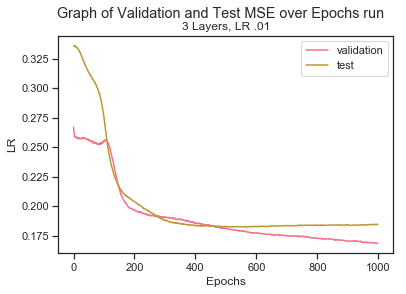

In [737]:
r = range(epochs_run+1)
plt.plot([*r],error_list_valid,label='validation')
plt.plot([*r],error_list_train,label='test')
plt.legend()
plt.suptitle('Graph of Validation and Test MSE over Epochs run')
plt.title('3 Layers, LR .01')
plt.xlabel('Epochs')
plt.ylabel('LR')

Text(0,0.5,'True Positive Rate')

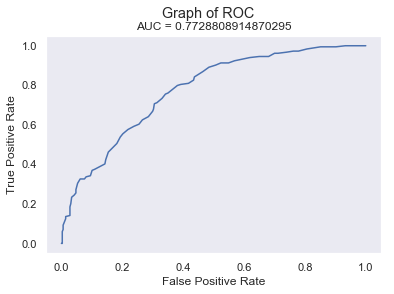

In [747]:
plt.plot(fpr,tpr)
plt.suptitle('Graph of ROC',label='roc')
plt.title('AUC = {0}'.format(roc_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [740]:
predictions,_ = NN.feed_forward(test)
pd_prob = pd.DataFrame(prediction[-1])
print(prediction[-1])
# pd_prob.columns = ['probability']
# pd_concat = pd_prob.join(concat_pos['sequence'])
# print(pd_concat.head())
# pd_concat.to_csv('probabilities.txt',sep='\t',header=True,index=False)

[[0.02 0.19 0.07 0.11 0.06 0.15 0.13 0.02]
 [0.03 0.22 0.12 0.16 0.07 0.18 0.17 0.05]
 [0.01 0.1  0.03 0.11 0.04 0.07 0.1  0.01]
 [0.02 0.17 0.06 0.1  0.06 0.14 0.11 0.03]
 [0.02 0.13 0.04 0.11 0.09 0.08 0.09 0.02]
 [0.05 0.17 0.08 0.18 0.17 0.08 0.2  0.02]
 [0.03 0.14 0.08 0.12 0.08 0.12 0.19 0.04]
 [0.04 0.13 0.05 0.18 0.13 0.07 0.12 0.02]]


/usr/local/lib/python3.7/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


IndexError: list index out of range

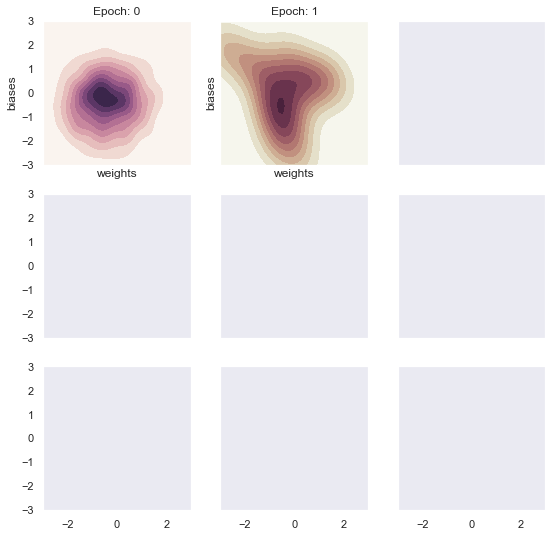

In [739]:
sns.set(style="dark")
f, axes = plt.subplots(3, 3, figsize=(9, 9), sharex=True, sharey=True)
index_nn = [0,1,2,3,4,5,6,7,8]
for (i,ax,s) in zip(index_nn,axes.flat, np.linspace(0, 3, 10)):
    cmap = sns.cubehelix_palette(start=s, light=1, as_cmap=True)
    tot_w = len(NN.weights[i])*len(NN.weights[i].T)    
    x=NN.weights[i].reshape(int(tot_w/2),2)    
    y=NN.biases[i].reshape(len(NN.biases[i]),1)
    sns.kdeplot(x, y, cmap=cmap, shade=True, cut=5, ax=ax)
    ax.title.set_text('Epoch: {0}'.format(i))
    ax.set_xlabel('weights')
    ax.set_ylabel('biases')
    ax.set(xlim=(-3, 3), ylim=(-3, 3))
f.tight_layout()
outdir = pathlib.Path('images')
outfile = outdir / "Weights-biases.png"
outdir.mkdir(parents=True, exist_ok=True)
plt.savefig(str(outfile),format='png')
plt.close()

In [386]:
tot_w = len(NN.weights[2])*len(NN.weights[2].T)
# NN.weights[2].reshape(int(tot_w/2),2)
len(NN.weights[2].T)

34

In [375]:
index_nn = range(8)
index_nn

range(0, 8)

In [440]:
# print(prediction[-1].shape)
# y.shape.reshape()

(8, 8)


In [669]:
# cat['binary'] = [make_binary_sequence(seq) for seq in cat['sequence']]

def reverse_binary_dictionary(sequence):
    '''
    dicationary with reverse complement nucs
    '''
    binDict = {'1000':'A','0100':'C','0010':'G','0001':'T'}
    list_str = [str(i) for i in sequence]
    join_str = "".join(list_str)
    parse_str = [join_str[0+i:4+i] for i in range(0, len(join_str), 4)]
    return "".join([binDict[i] for i in parse_str])


cat['rev_binary'] = [reverse_binary_dictionary(c) for c in cat['binary']]
assert all(cat['sequence'].head()==cat['rev_binary'].head())


In [475]:
test = np.zeros((16,), dtype=np.int)
size = int(len(test)/4.0)
range(1,size)

range(1, 4)

In [685]:
pd_p = pd.DataFrame(predictions[-1])
pd_p.columns = ['probability']
pd_predict = pd_p.join(seq_test['sequence'])
print(pd_predict.head())
pd_predict.to_csv('probabilities.txt',sep='\t',header=False,index=False)

   probability           sequence
0         0.05  AAAAAAACGCAACTAAT
1         0.45  AAAAACACACATCTGGC
2         0.19  AAAACCAAACACCTGAA
3         0.24  AAAACCAAACAGCTCAG
4         0.12  AAAACCAAACATATCAA
